In [1]:
from photerr import LsstErrorModel
import pandas as pd
import numpy as np
import lbg_forecast.noise as noise
import lbg_forecast.emulator as em
import lbg_forecast.nz_sim as nz
import matplotlib.pyplot as plt

2024-01-18 16:30:33.646642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-18 16:30:33.646660: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-18 16:30:33.646673: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-18 16:30:33.646699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-18 16:30:33.646713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
noiseless_photometry = np.load("/Users/fpetri/repos/LBGforecast/data/data/training_data.npy")[:200000, :6]
sps_params = np.load("/Users/fpetri/repos/LBGforecast/data/data/training_params.npy")[:200000, :]
catalog = pd.DataFrame(noiseless_photometry, columns=['u', 'g', 'r', 'i', 'z', 'y'])

In [3]:
random_state=42
errModel = LsstErrorModel(sigLim=0, absFlux=True)
sig5detections = LsstErrorModel(sigLim=5)
sig2detections = LsstErrorModel(sigLim=2)

observed_catalog = errModel(catalog, random_state=random_state).filter(['u', 'g', 'r', 'i', 'z', 'y']).replace([np.inf, -np.inf], np.nan, inplace=False)

catalog_sig5 = sig5detections(observed_catalog, random_state=random_state).filter(['u', 'g', 'r', 'i', 'z', 'y']).replace([np.inf, -np.inf], np.nan, inplace=False)
catalog_sig5.rename(columns={"u": "u5", "g": "g5", "r": "r5", "i": "i5", "z": "z5", "y": "y5" }, inplace=True)

catalog_sig2 = sig2detections(observed_catalog, random_state=random_state).filter(['u', 'g', 'r', 'i', 'z', 'y']).replace([np.inf, -np.inf], np.nan, inplace=False)
catalog_sig2.rename(columns={"u": "u2", "g": "g2", "r": "r2", "i": "i2", "z": "z2", "y": "y2" }, inplace=True)

observed_catalog = observed_catalog.join(catalog_sig5).join(catalog_sig2)

In [4]:
observed_catalog

,u,g,r,i,z,y,u5,g5,r5,i5,z5,y5,u2,g2,r2,i2,z2,y2
0,29.077212,29.006471,29.355314,28.511281,27.365579,24.419026,NaN,NaN,NaN,NaN,NaN,24.552852,NaN,NaN,NaN,27.841580,NaN,24.552852
1,20.661355,20.635699,20.163962,20.311902,20.371887,20.442743,20.660658,20.637301,20.164046,20.316226,20.367368,20.438331,20.660658,20.637301,20.164046,20.316226,20.367368,20.438331
2,27.425175,26.793837,26.826197,27.103724,26.704071,28.643803,NaN,26.649376,26.763150,NaN,NaN,NaN,NaN,26.649376,26.763150,27.364204,26.586722,NaN
3,27.929121,32.361441,30.941260,29.078675,27.727271,29.364477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.990785,NaN
4,18.313505,18.286843,17.997658,18.049663,18.083339,18.031653,18.315667,18.288610,17.994992,18.047832,18.081270,18.029488,18.315667,18.288610,17.994992,18.047832,18.081270,18.029488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,18.668041,17.887372,16.998481,16.994679,14.964775,17.247585,18.671971,17.889857,16.998413,16.988181,14.970040,17.248898,18.671971,17.889857,16.998413,16.988181,14.970040,17.248898
199996,27.823959,27.325088,26.201250,25.387735,24.812858,24.593528,NaN,NaN,26.248569,25.336005,24.718988,24.769583,NaN,27.303501,26.248569,25.336005,24.718988,24.769583
199997,28.260633,30.283730,28.531848,26.714609,26.138560,25.379281,NaN,NaN,NaN,26.588974,25.927332,25.033151,NaN,NaN,28.090004,26.588974,25.927332,25.033151
199998,27.148460,28.397647,29.034350,30.249718,28.918136,29.046265,NaN,NaN,NaN,NaN,NaN,NaN,26.395195,NaN,28.281772,NaN,NaN,NaN


In [5]:

brightness_cut = 19
observed_catalog.dropna(axis=0, subset=['i5'], inplace=True) #require 5sigma detection in i band
observed_catalog.drop(observed_catalog[observed_catalog['i5'] < brightness_cut].index, inplace=True)
observed_catalog


,u,g,r,i,z,y,u5,g5,r5,i5,z5,y5,u2,g2,r2,i2,z2,y2
1,20.661355,20.635699,20.163962,20.311902,20.371887,20.442743,20.660658,20.637301,20.164046,20.316226,20.367368,20.438331,20.660658,20.637301,20.164046,20.316226,20.367368,20.438331
9,28.607734,29.551780,26.678613,25.269228,24.819414,24.586305,NaN,NaN,26.712498,25.196724,24.872299,24.482306,NaN,NaN,26.712498,25.196724,24.872299,24.482306
11,22.876032,22.003866,20.548669,21.238673,20.012281,21.216944,22.880734,22.006354,20.544348,21.239669,20.018795,21.225208,22.880734,22.006354,20.544348,21.239669,20.018795,21.225208
15,27.711542,27.140973,25.679089,24.503926,23.591683,25.233829,NaN,27.159701,25.699873,24.505942,23.625896,NaN,NaN,27.159701,25.699873,24.505942,23.625896,25.579006
16,26.006904,24.272420,23.578712,23.257801,23.050582,22.889766,NaN,24.287070,23.575223,23.266378,23.055448,22.858651,26.329785,24.287070,23.575223,23.266378,23.055448,22.858651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,28.057281,31.122527,25.960338,25.506594,25.214915,25.249786,NaN,NaN,25.905256,25.439201,25.094231,NaN,NaN,NaN,25.905256,25.439201,25.094231,25.325803
199994,27.945119,30.187125,25.139737,22.079970,17.447989,17.484596,NaN,NaN,25.166464,22.090405,17.445670,17.478575,NaN,NaN,25.166464,22.090405,17.445670,17.478575
199996,27.823959,27.325088,26.201250,25.387735,24.812858,24.593528,NaN,NaN,26.248569,25.336005,24.718988,24.769583,NaN,27.303501,26.248569,25.336005,24.718988,24.769583
199997,28.260633,30.283730,28.531848,26.714609,26.138560,25.379281,NaN,NaN,NaN,26.588974,25.927332,25.033151,NaN,NaN,28.090004,26.588974,25.927332,25.033151


In [6]:
def select_u_dropouts(observed_catalog):
    
    udrop = observed_catalog.copy(deep=True)

    udrop = udrop.dropna(axis=0, subset=['i5'])
    udrop = udrop.dropna(axis=0, subset=['r5'])
    udrop = udrop.dropna(axis=0, subset=['g5'])
    udrop = udrop.dropna(axis=0, subset=['u5'])

    return udrop.filter(['u','g','r','i','z','y'])

def select_g_dropouts(observed_catalog):
    
    gdrop = observed_catalog.copy(deep=True)

    gdrop = gdrop.dropna(axis=0, subset=['i5'])
    gdrop = gdrop.dropna(axis=0, subset=['r5'])
    gdrop = gdrop.dropna(axis=0, subset=['g5'])
    gdrop = gdrop.drop(gdrop[np.isnan(gdrop.u2) == False].index)

    
    return gdrop.filter(['u','g','r','i','z','y'])

def select_r_dropouts(observed_catalog):

    rdrop = observed_catalog.copy(deep=True)
    rdrop = rdrop.dropna(axis=0, subset=['z5'])
    rdrop = rdrop.dropna(axis=0, subset=['i5'])
    rdrop = rdrop.dropna(axis=0, subset=['r5'])
    rdrop = rdrop.drop(rdrop[np.isnan(rdrop.g2) == False].index)
    
    return rdrop.filter(['u','g','r','i','z','y'])

In [7]:
select_r_dropouts(observed_catalog)

,u,g,r,i,z,y
9,28.607734,29.551780,26.678613,25.269228,24.819414,24.586305
22,28.281610,31.848635,25.829620,22.948710,22.547465,22.218772
24,28.013735,29.998608,26.902024,24.374690,24.538475,24.145958
49,29.354003,29.363986,26.402096,25.927107,25.615316,25.050883
85,27.367625,29.854561,27.287604,24.963824,24.517430,24.205312
...,...,...,...,...,...,...
199929,29.018112,28.744313,23.264996,20.928290,18.209390,18.775063
199930,28.660943,28.410752,25.940647,25.242115,24.739708,24.327083
199954,28.287188,30.760676,23.832251,20.506518,18.381772,18.581163
199993,28.057281,31.122527,25.960338,25.506594,25.214915,25.249786


In [8]:
obs_mags = noise.get_noisy_magnitudes(sps_params, noiseless_photometry)


In [9]:
def plot_realisation(realisation, nz_data, bins, alpha):
    
    plt.bar(bins[:-1], nz_data[realisation][0], width=np.diff(bins), edgecolor="black", align="edge", alpha=alpha, lw=0.5, color = 'blue')
    plt.bar(bins[:-1], nz_data[realisation][1], width=np.diff(bins), edgecolor="black", align="edge", alpha=alpha, lw=0.5, color = 'red')
    plt.bar(bins[:-1], nz_data[realisation][2], width=np.diff(bins), edgecolor="black", align="edge", alpha=alpha, lw=0.5, color = 'green' )

In [10]:
# initalise fsps emulator
model = em.fsps_emulator()

# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0

bins = np.arange(minz, maxz, dz)

nzs = [nz.simulate_nzs(sps_params, model, bins)]

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


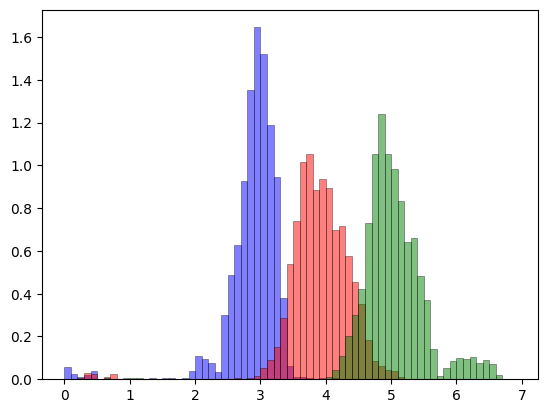

In [11]:
plot_realisation(0, nzs, bins, alpha=0.5)